# Solving the one-band Hubbard model with RISB impurity solver

by Pak Ki Henry Tsang, Apr 2021

email: henrytsang222@gmail.com / tsang@magnet.fsu.edu

In [1]:
import numpy as np
import os

import matplotlib.pyplot as plt

# Parameters


norb : Number of orbitals. Since each orbital has 2 spins, for single-band case this number is 2.

In [2]:
norb=2 #Number of orbitals

# Routine to create a flat bath ( Hybridization function $\Delta(\omega)$ )

Note that in the current implementation of impurity solver, the frequency grid $\omega$ comes from the grid where hybridization function is defined on. If for some reason linearly spaced frequency points is not desirable, one can first take a bath defined on linear grid, then interpolate for frequencies in between and save to file.

The flat bath is used here just for convenience. In actual use one might want to take a converged spectrum instead.

In [3]:
D0=0.1 
B=1.0

grid_size=10000 #number of real frequency points

def Create_Flat_Delta(norb,D=6,Delta_FN='Delta.inp'):
    omega_grid=np.linspace(-D,D,10000)
        
    Delta0_grid=[]
    for om in omega_grid:
        Delta0=-1.j*D0
        Delta0+=-D0*np.log((B-om)/(B+om)+0.j).real/np.pi
        Delta0_matrix=np.eye(norb)*Delta0
        Delta0_matrix.resize(norb**2)
        Delta0_grid.append(np.hstack((om,Delta0_matrix)))
    Delta0_grid=np.array(Delta0_grid)
    np.savetxt(Delta_FN,Delta0_grid)
    
    
Create_Flat_Delta(norb)

# Running the code to solve one-band Hubbard model (Jupyter notebook style)

The file "solver.py" can be ran in the command line directly. But for demonstration purposes, we're going to use directly the routines inside so that we can access the internal memory easily.

In [4]:
from python.impurity import *
    
#We want to first read in hybridization function for many orbitals, it should be arranged in the following manner
#omega reDelta00 imDelta00 reDelta01 imDelta01 

Delta_input=np.loadtxt('Delta.inp',dtype=complex)

grid_size=len(Delta_input)

Delta_grid=[]
omega_grid=[]
for row in Delta_input:
    omega_grid.append(row[0]) #First element in row is the frequency
    Delta_grid.append(row[1:]) #The remainder is hybridization function
omega_grid=np.array(omega_grid) #Cast as numpy array
Delta_grid=np.array(Delta_grid).reshape(grid_size,norb,norb) #Cast as numpy array


#Next is to read in on-site and inter-site energies, it should look like
# 0 0 0.0    #e0
# 1 1 -1.0    #e1
# ...

#Next is to read in two-body terms
# 0 0 1 1 1.0    #U01
# 1 1 0 0 1.0    #U10
# ...

def get_one_body_tensor(mu):
    
    #We directly print the one-body tensor to file and proceed to read it back
    
    one_body_tensor_text="""#The format is
#
#orbital_label1 orbital_label2 energy
#
#Say, for one-orbital impurity of site energy 0, then this file should look like
#
#0 0 0.0
#1 1 0.0
#
#We need labels 0 and 1 because of two spins acting like two orbitals instead of one
#
0 0 0.0
1 1 0.0"""
    
    with open('one_body.inp','w') as f:
        print(one_body_tensor_text,file=f)
    
    ob_tensor = np.zeros((norb,norb),dtype=float) #initialize tensor
    for line in open('one_body.inp'):
        if line.startswith('#'):
            continue
        ls=line.split()
        idx1=int(ls[0])
        idx2=int(ls[1])
        en=float(ls[2])
        ob_tensor[idx1,idx2]=en
    for idx in range(norb):
        ob_tensor[idx,idx]-=mu
    return ob_tensor

def get_two_body_tensor(U):
    
    #We directly print the two-body tensor to file and proceed to read it back
    
    two_body_tensor_text="""#The format is
#
#orbital_label1 orbital_label2 orbital_label3 orbital_label4 interaction_strength
#
#Say, we have an orbital where label 0 is spin up and label 1 is spin down, effectively a two-orbital problem
#interaction is H_{int}=U*f^{dagger}_{0}*f_{0}*f^{dagger}_{1}*f_{1}, where we choose U=1.0, then this file should look like
#
#0 0 1 1 0.5
#1 1 0 0 0.5
#
#Where interaction strength is U/2 to not double-count
#
0 0 1 1 %f
1 1 0 0 %f"""%(U/2,U/2)
    
    with open('two_body.inp','w') as f:
        print(two_body_tensor_text,file=f)
    
    
    tb_tensor = np.zeros((norb,norb,norb,norb),dtype=float) #initialize tensor
    for line in open('two_body.inp'):
        if line.startswith('#'):
            continue
        ls=line.split()
        idx1=int(ls[0])
        idx2=int(ls[1])
        idx3=int(ls[2])
        idx4=int(ls[3])
        en=float(ls[4])
        tb_tensor[idx1,idx2,idx3,idx4]=en   #up up down down
        
    return tb_tensor


#Next is to read in the guesses of R-matrix and lambda-matrix. 

#Read in R
R0=np.zeros(norb**2,dtype=complex)
for line in open('R.inp'):
    if line.startswith('#'):
        continue
    ls=line.split()
    length=len(ls)
    assert(length==norb**2)
    for idx in range(length):
        R0[idx]=complex(ls[idx])
R0.resize(norb,norb)

#Read in lambda
l0=np.zeros(norb**2,dtype=complex)
for line in open('lambda.inp'):
    if line.startswith('#'):
        continue
    ls=line.split()
    length=len(ls)
    assert(length==norb**2)
    for idx in range(length):
        l0[idx]=complex(ls[idx])
l0.resize(norb,norb)

### DMFT parameters

In [5]:
U=3.0 #Hubbard U
mu=U/2.0 #chemical potential for half-filled Hubbard model is mu=U/2
t=1.0 #Hopping strength
eta=5e-2 #Broadening. In general DMFT convergence is faster when eta is larger, but one would also want to use a smaller value to avoid having too much smearing.

ob_tensor=get_one_body_tensor(mu)
tb_tensor=get_two_body_tensor(U)


# Initialize the solver, technically, it is possible to use just one instance of the solver to solver different U, you just need to modify the two-body tensor 'tb_tensor' inside the class object

RISB_solver=RISB_impurity(omega_grid,ob_tensor,tb_tensor,norb,eta=eta)

/home/henry/Dropbox/Impurity/RISB_Impurity_21.0/python/impurity.py:86: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(omega/T))


### DMFT self-consistency loop

In [6]:
for i in range(10):
    G_grid,R,l=RISB_solver.solve(Delta_grid,R0,l0,xtol=1e-6,eps=1e-10,factor=1,paramagnetic=True)
    Delta_grid=t**2*G_grid #With semicircular density of states, Delta=t^2*G

MAXERR= 0.21219139708087692
MAXERR= 0.21219139708087692
MAXERR= 0.21219139708087692
MAXERR= 0.21219507535675175
MAXERR= 0.212191280877074
MAXERR= 0.21219346521602572
MAXERR= 0.034020477695085316
MAXERR= 0.2037764748984704
MAXERR= 0.11743441197279814
MAXERR= 0.03401998857328625
MAXERR= 0.034020477695085316
MAXERR= 0.0340201828166623
MAXERR= 0.0306621238414998
MAXERR= 0.011367145125026568
MAXERR= 0.0005972303199790197
MAXERR= 0.00012963246347699742
MAXERR= 9.571215120462995e-08
MAXERR= 4.713815560108969e-09
MAXERR= 3.9423192488285963e-10
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.2013305263189889
MAXERR= 0.2013305263189889
MAXERR= 0.2013305263189889
MAXERR= 0.20133559339094276
MAXERR= 0.20133046157064094
MAXERR= 0.20133047363902434
MAXERR= 0.0006244685074125456
MAXERR= 3.4522786357071844e-05
MAXERR= 2.643130062807142e-05
MAXERR= 1.2046101227625172e-08
MAXERR= 4.604649994632837e-12
RISB root convergence message------------

Plotting to see the progress, likely convergence is poor if we select small eta. It is easy to waste a lot of time trying to converge this.

/home/henry/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/henry/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


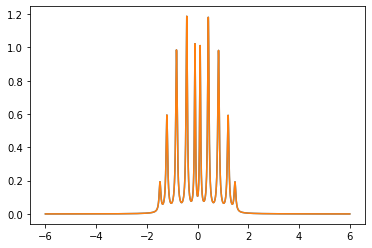

In [7]:
plt.plot(omega_grid,-G_grid[:,0,0].imag/np.pi)
plt.plot(omega_grid,-G_grid[:,1,1].imag/np.pi)
plt.show()

We can greatly speed up the progress by using the mixing strategy, that is, to average between the new bath/hybridization function from self-consistency equation, and bath from previous iteration.

In [8]:
#Re-read the initial condition to compare between mixing and no mixing

Delta_input=np.loadtxt('Delta.inp',dtype=complex)

grid_size=len(Delta_input)

Delta_grid=[]
omega_grid=[]
for row in Delta_input:
    omega_grid.append(row[0]) #First element in row is the frequency
    Delta_grid.append(row[1:]) #The remainder is hybridization function
omega_grid=np.array(omega_grid) #Cast as numpy array
Delta_grid=np.array(Delta_grid).reshape(grid_size,norb,norb) #Cast as numpy array


#Employing mixing strategy

for i in range(10):
    G_grid,R,l=RISB_solver.solve(Delta_grid,R0,l0,xtol=1e-6,eps=1e-10,factor=1,paramagnetic=True)
    previous_Delta_grid=Delta_grid
    Delta_grid=0.5*(t**2*G_grid+previous_Delta_grid) #Now we do some 50-50 mixing, but it is also possible to use other ratios

MAXERR= 0.21219139708087692
MAXERR= 0.21219139708087692
MAXERR= 0.21219139708087692
MAXERR= 0.21219507535675175
MAXERR= 0.212191280877074
MAXERR= 0.21219346521602572
MAXERR= 0.034020477695085316
MAXERR= 0.2037764748984704
MAXERR= 0.11743441197279814
MAXERR= 0.03401998857328625
MAXERR= 0.034020477695085316
MAXERR= 0.0340201828166623
MAXERR= 0.0306621238414998
MAXERR= 0.011367145125026568
MAXERR= 0.0005972303199790197
MAXERR= 0.00012963246347699742
MAXERR= 9.571215120462995e-08
MAXERR= 4.713815560108969e-09
MAXERR= 3.9423192488285963e-10
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.19257926337758102
MAXERR= 0.19257926337758102
MAXERR= 0.19257926337758102
MAXERR= 0.1925837893335623
MAXERR= 0.19257919044150634
MAXERR= 0.19257978173616258
MAXERR= 0.002269541934189989
MAXERR= 0.0015248153884791504
MAXERR= 0.0007171630337216017
MAXERR= 1.142174846546773e-05
MAXERR= 3.1718354209786526e-07
MAXERR= 1.1463015037183055e-08
MAXERR= 8.

One should see substantial improvement over doing no mixing at all

/home/henry/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/henry/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


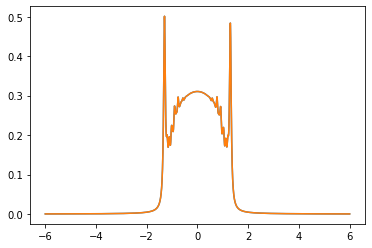

In [9]:
plt.plot(omega_grid,-G_grid[:,0,0].imag/np.pi)
plt.plot(omega_grid,-G_grid[:,1,1].imag/np.pi)
plt.show()

another strategy to facilitate convergence can be decreasing eta with each iteration, which is easy to do

In [10]:
#Re-read the initial condition

Delta_input=np.loadtxt('Delta.inp',dtype=complex)

grid_size=len(Delta_input)

Delta_grid=[]
omega_grid=[]
for row in Delta_input:
    omega_grid.append(row[0]) #First element in row is the frequency
    Delta_grid.append(row[1:]) #The remainder is hybridization function
omega_grid=np.array(omega_grid) #Cast as numpy array
Delta_grid=np.array(Delta_grid).reshape(grid_size,norb,norb) #Cast as numpy array

#eta-decreasing strategy

RISB_solver.eta=1e-1 #Directly set the eta inside the solver to be 1e-1

for i in range(10):
    G_grid,R,l=RISB_solver.solve(Delta_grid,R0,l0,xtol=1e-6,eps=1e-10,factor=1,paramagnetic=True)
    Delta_grid=t**2*G_grid #With semicircular density of states, Delta=t^2*G
    
    RISB_solver.eta*=0.933 #Decrease eta on-the-fly

MAXERR= 0.22433657779126726
MAXERR= 0.22433657779126726
MAXERR= 0.22433657779126726
MAXERR= 0.2243403106804876
MAXERR= 0.22433643126233183
MAXERR= 0.22433810448361635
MAXERR= 0.03295323347402246
MAXERR= 0.2325666217033031
MAXERR= 0.15218640765682556
MAXERR= 0.03295272634964985
MAXERR= 0.03295323347402246
MAXERR= 0.03295294006677685
MAXERR= 0.03630694550967534
MAXERR= 0.016221969479613962
MAXERR= 0.0007870830890124303
MAXERR= 0.00018694371730704207
MAXERR= 4.382161012506103e-06
MAXERR= 3.9271520613226585e-07
MAXERR= 7.522859224451395e-09
MAXERR= 9.043321647084213e-12
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.23461037785779748
MAXERR= 0.23461037785779748
MAXERR= 0.23461037785779748
MAXERR= 0.23461552755491388
MAXERR= 0.2346103170851443
MAXERR= 0.23461027296028442
MAXERR= 0.000857325919464802
MAXERR= 0.0006447684502457474
MAXERR= 0.000342956758505486
MAXERR= 1.8406957350003417e-06
MAXERR= 5.7600779146405046e-08
MAXERR= 2.

This should be slightly better than no mixing. In practice, one can employ a combination of both strategy.

/home/henry/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/henry/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


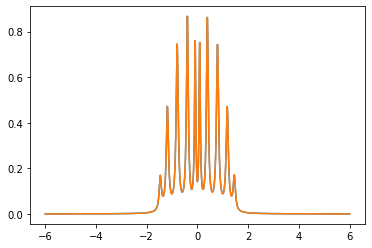

In [11]:
plt.plot(omega_grid,-G_grid[:,0,0].imag/np.pi)
plt.plot(omega_grid,-G_grid[:,1,1].imag/np.pi)
plt.show()

one can conveniently access important quantities calculated inside the solver when using the ipython kernal, say

In [12]:
print("Delta_p=\n",RISB_solver.Delta_p)
print("D=\n",RISB_solver.D)

Delta_p=
 [[0.5+0.j 0. +0.j]
 [0. +0.j 0.5+0.j]]
D=
 [[-0.72272865+0.j  0.        +0.j]
 [ 0.        +0.j -0.72272865+0.j]]


### calculating Z vs U

We want to loop over U, and get quasiparticle weight Z(U)

In [13]:
t=1.0 #Hopping strength
eta=5e-2 #Broadening. In general DMFT convergence is faster when eta is larger, but one would also want to use a smaller value to avoid having too much smearing.

U_list=[1.0,2.0,3.0,4.0,5.0,6.0]
Z_list=[]


for U in U_list:
    mu=U/2.0 #chemical potential for half-filled Hubbard model is mu=U/2
    ob_tensor=get_one_body_tensor(mu)
    tb_tensor=get_two_body_tensor(U)

    RISB_solver=RISB_impurity(omega_grid,ob_tensor,tb_tensor,norb,eta=eta)
    
    
    for i in range(20):
        G_grid,R,l=RISB_solver.solve(Delta_grid,R0,l0,xtol=1e-6,eps=1e-10,factor=1,paramagnetic=True)
        previous_Delta_grid=Delta_grid
        Delta_grid=0.5*(t**2*G_grid+previous_Delta_grid) #Now we do some 50-50 mixing, but it is also possible to use other ratios
    Z_list.append(R[0,0]**2)

/home/henry/Dropbox/Impurity/RISB_Impurity_21.0/python/impurity.py:86: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(omega/T))


MAXERR= 0.006975764691171282
MAXERR= 0.006975764691171282
MAXERR= 0.006975764691171282
MAXERR= 0.006980741572998939
MAXERR= 0.006975748829168349
MAXERR= 0.006975736012550804
MAXERR= 7.213919722137696e-05
MAXERR= 1.433153928809272e-06
MAXERR= 5.25939125584074e-10
MAXERR= 8.388845174067683e-13
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.006295399999520279
MAXERR= 0.006295399999520279
MAXERR= 0.006295399999520279
MAXERR= 0.006300378245995664
MAXERR= 0.006295384766047574
MAXERR= 0.006295370018765456
MAXERR= 7.103422762788636e-05
MAXERR= 1.149134996658585e-06
MAXERR= 6.563551924188005e-10
MAXERR= 1.4598877662308496e-12
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.006045946871396979
MAXERR= 0.006045946871396979
MAXERR= 0.006045946871396979
MAXERR= 0.006050925217439329
MAXERR= 0.006045931721571862
MAXERR= 0.006045917021140712
MAXERR= 6.909905226903934e-05
MAXERR= 

MAXERR= 0.022938739581138123
MAXERR= 0.022938739581138123
MAXERR= 0.022938739581138123
MAXERR= 0.022943660999136584
MAXERR= 0.022938684081012017
MAXERR= 0.022938707869473107
MAXERR= 0.0002583728129071927
MAXERR= 2.0403459482842834e-05
MAXERR= 7.973624538415436e-09
MAXERR= 1.5357937144244715e-11
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.02325980910227926
MAXERR= 0.02325980910227926
MAXERR= 0.02325980910227926
MAXERR= 0.023264730393699418
MAXERR= 0.023259753555118112
MAXERR= 0.023259777452399044
MAXERR= 0.00025950894691906257
MAXERR= 2.076980823151331e-05
MAXERR= 8.126130712771129e-09
MAXERR= 1.8023471604067254e-11
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.02341705696921198
MAXERR= 0.02341705696921198
MAXERR= 0.02341705696921198
MAXERR= 0.023421978328239168
MAXERR= 0.02341700146731923
MAXERR= 0.023417025367415634
MAXERR= 0.00025999112124730495
MAXERR= 2.

MAXERR= 2.5163759964641486e-12
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.05230316972049914
MAXERR= 0.05230316972049914
MAXERR= 0.05230316972049914
MAXERR= 0.05230801780779548
MAXERR= 0.05230306343546631
MAXERR= 0.05230313576723655
MAXERR= 0.0005362783138721516
MAXERR= 0.00010904205536421685
MAXERR= 3.051483052352033e-06
MAXERR= 1.8326930639744887e-08
MAXERR= 6.527001161771295e-13
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.05297968826082822
MAXERR= 0.05297968826082822
MAXERR= 0.05297968826082822
MAXERR= 0.05298453688609889
MAXERR= 0.0529795822820639
MAXERR= 0.052979654349947614
MAXERR= 0.0005372356040914683
MAXERR= 0.00011065127155562848
MAXERR= 3.2727354184469704e-06
MAXERR= 1.978149855030864e-08
MAXERR= 6.217248937900877e-13
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.05335338932282507
M

MAXERR= 0.00033483604745326856
MAXERR= 8.072907033662702e-05
MAXERR= 9.222043696466287e-07
MAXERR= 3.4226492751088244e-09
MAXERR= 2.3884672017970843e-11
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.09343293726040547
MAXERR= 0.09343293726040547
MAXERR= 0.09343293726040547
MAXERR= 0.09343772330808764
MAXERR= 0.09343278917081244
MAXERR= 0.09343290069043841
MAXERR= 0.0011730368694677362
MAXERR= 0.0003464470138727638
MAXERR= 9.19779730053083e-05
MAXERR= 1.05685570972458e-06
MAXERR= 4.073857473585463e-09
MAXERR= 2.9761970665731496e-11
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.09539848601542344
MAXERR= 0.09539848601542344
MAXERR= 0.09539848601542344
MAXERR= 0.0954032745274474
MAXERR= 0.09539833922123098
MAXERR= 0.0953984494086687
MAXERR= 0.0012227569922167447
MAXERR= 0.00035331757268436403
MAXERR= 9.921615074259815e-05
MAXERR= 1.141260176695802e-06
MAXERR= 4.487

MAXERR= 0.13379534216216693
MAXERR= 0.13379534216216693
MAXERR= 0.1338000979513898
MAXERR= 0.13379517124176815
MAXERR= 0.1337953040174204
MAXERR= 0.0031135679133898475
MAXERR= 0.0007174788138685773
MAXERR= 0.0004796975137273396
MAXERR= 4.2668630869657775e-06
MAXERR= 2.663471410091489e-08
MAXERR= 2.691302736224088e-10
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.1421518804416615
MAXERR= 0.1421518804416615
MAXERR= 0.1421518804416615
MAXERR= 0.14215663866961642
MAXERR= 0.1421517137861315
MAXERR= 0.1421518414638901
MAXERR= 0.003553475529863126
MAXERR= 0.0007496536272685872
MAXERR= 0.0005692917886204185
MAXERR= 2.62857175725717e-06
MAXERR= 1.6745278275109854e-08
MAXERR= 1.2312961761296037e-10
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.148291633504204
MAXERR= 0.148291633504204
MAXERR= 0.148291633504204
MAXERR= 0.14829639920910254
MAXERR= 0.14829147132130743
MAXE

MAXERR= 0.16542906538373764
MAXERR= 0.16542906538373764
MAXERR= 0.16542906538373764
MAXERR= 0.16543386401043697
MAXERR= 0.1654289185619508
MAXERR= 0.16542902499531142
MAXERR= 0.004595357862277827
MAXERR= 0.0007457554197483618
MAXERR= 0.0007448837867441993
MAXERR= 1.3821565739868813e-05
MAXERR= 6.613853675840886e-08
MAXERR= 5.757810339623859e-10
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.1999362103063677
MAXERR= 0.1999362103063677
MAXERR= 0.1999362103063677
MAXERR= 0.1999410011402708
MAXERR= 0.19993605777489276
MAXERR= 0.19993616949626974
MAXERR= 0.007619944212087226
MAXERR= 0.0008839033375873107
MAXERR= 0.0014020606228387633
MAXERR= 0.0002458717876206995
MAXERR= 6.525312152716456e-05
MAXERR= 4.5816911153906403e-08
MAXERR= 2.205005900091095e-09
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.21176665878617001
MAXERR= 0.21176665878617001
MAXERR= 0.2117666587861

MAXERR= 9.358752525417957e-05
MAXERR= 5.465357825196193e-07
MAXERR= 5.950306580793097e-09
MAXERR= 6.707401301042637e-11
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.2733857471611565
MAXERR= 0.2733857471611565
MAXERR= 0.2733857471611565
MAXERR= 0.27339066180153415
MAXERR= 0.27338565683320193
MAXERR= 0.27338569860294326
MAXERR= 0.011048070336334953
MAXERR= 0.002970868439732821
MAXERR= 0.008469542659869267
MAXERR= 0.0006200698319714926
MAXERR= 8.275148342684613e-05
MAXERR= 5.518869592435749e-07
MAXERR= 4.829422195484767e-09
MAXERR= 4.503097894570374e-11
RISB root convergence message---------------------------------
sucess= True
The solution converged.
MAXERR= 0.27451573880013935
MAXERR= 0.27451573880013935
MAXERR= 0.27451573880013935
MAXERR= 0.2745206554086571
MAXERR= 0.27451564934009554
MAXERR= 0.27451569009236493
MAXERR= 0.011078258362899662
MAXERR= 0.003098092480838699
MAXERR= 0.008884538143618115
MAXERR= 0.00059559932673

/home/henry/.local/lib/python3.7/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


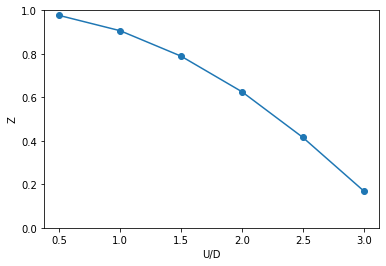

In [14]:
plt.plot(np.array(U_list)/2,Z_list,'-o')
plt.xlabel("U/D")
plt.ylabel("Z")
plt.ylim(0,1)
plt.show()